In [45]:
import numpy as np
np.random.seed(1337) 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer
from keras.models import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, LeakyReLU, Flatten, Dropout
from keras.callbacks import History, ModelCheckpoint
from keras import backend as K
from keras import metrics
from sklearn.metrics import confusion_matrix
import keras
import glob
import os
import itertools

In [3]:
# Load the data points
os.chdir('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/PDF-Cluster-Prediction/clusters/')

In [4]:
data_points = []

with open('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/PDF-Cluster-Prediction/clusters/labels.txt', 'w') as labels:
    files = glob.glob('*.dat')
    for f in files:
        #file_path = f"pdf_data/dataset_{i}.dat"
        df = pd.read_csv(f, usecols=[1], skiprows=1, header=None, delim_whitespace=True, skipfooter=0, engine='python')
        data_points.append(df.values.ravel())
        labels.write(f[0])
        labels.write('\n')

data_points = np.array(data_points)

# Load the labels
labels = pd.read_csv("labels.txt", header=None)
labels = labels.values.ravel()  # convert the labels to a 1D array

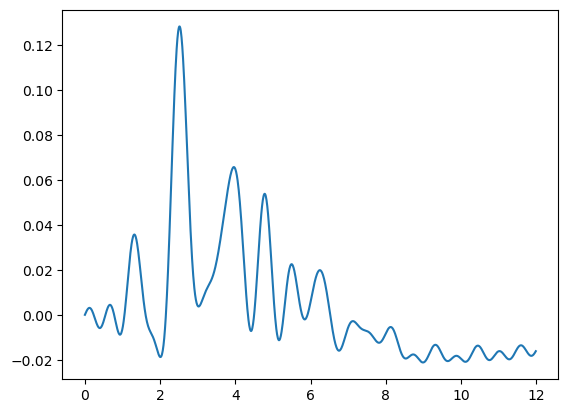

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
# Preprocessing
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler =MaxAbsScaler()
#data_points = scaler.fit_transform(data_points)
normalize = Normalizer()
data_points = normalize.fit_transform(data_points)
fig, ax = plt.subplots()
ax.plot(np.arange(len(data_points[56,:]))/100, data_points[56,:])

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_points, labels, test_size=0.1, random_state=42)

In [7]:
# Tuning of the model

model = Sequential()
# Add the convolutional layers
model.add(Conv1D(filters=256, kernel_size=32, activation='relu', input_shape=(1200,1))) # 256, 32
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) # 2
model.add(Conv1D(filters=64, kernel_size=32, activation='relu')) # 64, 32
model.add(MaxPooling1D(pool_size=2)) # 2
model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) # 32, 3
model.add(MaxPooling1D(pool_size=2)) # 2

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(units=64, activation='relu')) # 64
model.add(Dense(units=10, activation='softmax')) # 12

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # adam
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1169, 256)         8448      
                                                                 
 batch_normalization (BatchN  (None, 1169, 256)        1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 584, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 553, 64)           524352    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 276, 64)          0         
 1D)                                                             
                                                        

In [8]:
# Train the model
num_epochs = 100

checkpoint = ModelCheckpoint("best_model_tuning.hdf5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

seqModel = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/100


2023-01-26 16:20:57.139883: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - ETA: 0s - loss: 2.1230 - accuracy: 0.3111
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_model_tuning.hdf5
3/3 [==============================] - 2s 396ms/step - loss: 2.1230 - accuracy: 0.3111 - val_loss: 2.2273 - val_accuracy: 0.2000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.6702 - accuracy: 0.4667
Epoch 2: val_accuracy improved from 0.20000 to 0.30000, saving model to best_model_tuning.hdf5
3/3 [==============================] - 1s 316ms/step - loss: 1.6702 - accuracy: 0.4667 - val_loss: 2.2449 - val_accuracy: 0.3000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.4545 - accuracy: 0.4889
Epoch 3: val_accuracy improved from 0.30000 to 0.40000, saving model to best_model_tuning.hdf5
3/3 [==============================] - 1s 313ms/step - loss: 1.4545 - accuracy: 0.4889 - val_loss: 2.1865 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - ETA: 0s - los

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


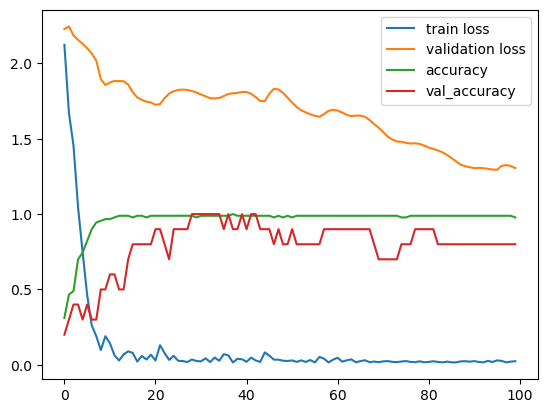

In [9]:
print(seqModel.history.keys())
xc         = range(num_epochs)

plt.plot(xc, seqModel.history['loss'], label='train loss')
plt.plot(xc, seqModel.history['val_loss'], label='validation loss')
plt.plot(xc, seqModel.history['accuracy'], label='accuracy')
plt.plot(xc, seqModel.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [21]:
load_model = keras.models.load_model('best_model_tuning.hdf5')

In [50]:
load_model.evaluate(X_train, y_train)
y_pred_prob = load_model.predict(X_train)
y_pred = np.argmax(y_pred_prob, axis=1)
confusion = confusion_matrix(y_train, y_pred)

3/3 [==============================] - 0s 120ms/step


Confusion matrix, without normalization
[[11  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 0  0 26  1  0  0  0  0]
 [ 0  0  0 10  0  0  0  0]
 [ 0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  6]]


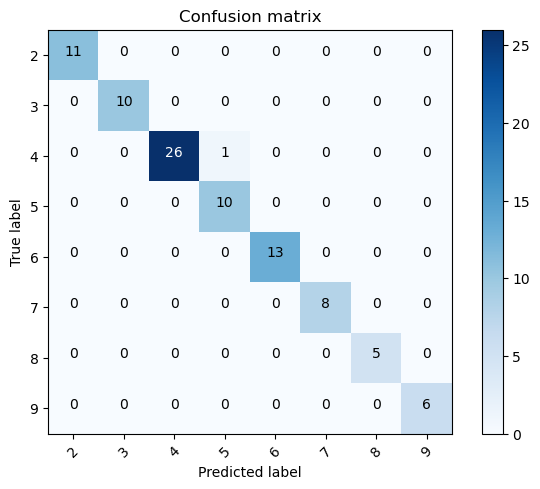

In [54]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion, classes = np.unique(y_train), title='Confusion matrix', normalize=False)
plt.show()

In [ ]:
# Load the new data points
new_data_points = []
for i in range(1, 11):
    file_path = f"path/to/new_data_{i}.csv"
    df = pd.read_csv(file_path, usecols=[1], skiprows=1, header=None)
    new_data_points.append(df.values.ravel())

new_data_points = np.array(new_data_points)

# Normalize the new data points using the same scaler
new_data_points = normalize.transform(new_data_points)

# Make predictions on the new data points
predictions = load_model.predict(new_data_points)